### Change from Version 0

### Changes from Version 1


1. Confine entire locations if the test result is positive
2. Removed (irrelevant) "is_dead" array
3. Removed all trace of "dead" states
4. Fixed error causing negative populations. Now, for `dt = 0.1` there should be no errors. The reason for errors is the following: in case there are more people that need to be moved from a compartment than there are in that compartment, the numbers are adjusted so that the total number of people moved from that becomes the maximum number currently in it, and the *fractions* of people moved remains the same. For example, if you had 7 people in a compartment (say I) an 10 had to move to R and 2 to H, then the code changes the numbers to $$n_{IR} = \Big[\frac{10}{12}\times 7 \Big] = 6 \\ n_{IH} = \Big[\frac{2}{12}\times 7 \Big] = 1$$ In the process of rounding the numbers, the result occasionally becomes greater than the total number.


### Changes from Version 3

1.Implemented reduced transmission for confined individuals

### Changes from Version 4

1. Removed periodic testing, introduced a fixed number of tests.
2. Parameter tc determines whether the test with be RAT (0) or PCR (1).




**Note:** Gillespie unchanged since v0

**TODO:**
1. [ ] Allow for different mixtures of tests
2. [ ] Change Gillespie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
from numpy.random import randint,uniform,choice

In [2]:
n_pop = 10000
n_loc = 2750
n_net = 250
n_overlap = 251
n_hospitals = 10 # Set the number of hospitals.

# |  L  |  L  |  L  |  L  |  L  |  L  |  L  |  L  | 
# |  N  |  N  |  N  | *N  | *N  |  N  |  -  |  -  | 
# |  -  |  -  |  -  | *H  | *H  |  H  |  H  |  H  |
# ___Only Networks__  (*OVERLAP) _______Homes_________


labels = [0,1,2,3,4]      # Number of states a person can be in, [S,A,I,R,H] (Not very important, just for bookkeeping)

person_attr = 4           # 4 attributes for a person: state, home, network, current location

### Rates #############

n_states = len(labels)
n_events = 6              # Different events in the model (currently) S->A, A->I, A->R, I->R, I->H, H->R
    
rate_array = np.zeros((n_states,n_states))

rate_array[0][1] = 0.8  # S -> A
rate_array[1][2] = 0.5  # A -> I
rate_array[1][3] = 0.1  # A -> R
rate_array[2][3] = 0.1  # I -> R
rate_array[2][4] = 0.25 # I -> H
rate_array[4][3] = 0.1  # H -> R


Cpars = [0,  1,  1,  0,  0.1, 0.1]  # Transmissivity of different individuals. Asymptomatic and symptomatics 
                                    # are just as infectious, hospitalised and quarantined are 10 times less infectious


In [3]:
## CREATE POPULATION #####

# def create_person(state, home):                  # Function to create a person with certain attributes
#     net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
#     return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


# pop = np.zeros((n_pop,person_attr),int)          # Empty population
# link_weight = np.zeros(n_pop,float)              # Array for link weights
# is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
# being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?

# n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
#                                                  # for all locations: both homes and networks
    
# test_type = np.zeros(n_pop,int)

    
# Initial populations ###########

n_asym = 10

n = np.array([n_pop-n_asym, n_asym, 0, 0, 0],int)
           # [S,            A,      I, R, H ]

old_n = np.copy(n)

##################################

# tc = 0

# for i in range(0,n_pop):
#     home = randint(n_overlap-1,n_loc)               # Assign random homes for remainder with random network
#     pop[i] = create_person(0,home)

#     n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

#     link_weight[i] = 1                             # This number must be between 0 and 1 (probability of shifting along link)
    
#     #if(pop[i][2]<n_hospitals or uniform(0.0,1.0) < tc):  # If the person works in a hospital, or with 50% chance
#     if(uniform(0.0,1.0) < tc):        
#         test_type[i] = 1                                  # Give them a high quality test
#     else:
#         test_type[i] = 0                                  # Otherwise give low-quality test

        
# r = choice(n_pop,size=n_asym,replace=False)         # Generate n_inf random numbers (r) from the total population without replacement


# np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to infected (1)

# i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

# np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
# np.add.at(n_per_location[:,1],i_locs,+1)           # Increment number of susceptible at these locations (idem)

# if(np.sum(n_per_location) != n_pop):
#     print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")

# old_n_per_location = np.copy(n_per_location)
# old_pop = np.copy(pop)

In [4]:
def Tau_Leap(rate, Cpars, Tpars, n0, old_pop, old_n_per_loc, T,home_loc_state,quarantine_confined,test_frac):
    
    test = Tpars
    
    pop = np.copy(old_pop)
    n_per_location = np.copy(old_n_per_loc)
    
    is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
    being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?
    loc_confined= np.zeros(n_loc,bool)               # Boolean array, is the location confined? <---NEW
    
    test_result = np.zeros(n_pop,int)                # Array to hold results of test (+1 positive, -1 negative)
    
    loc_confined_time = np.zeros(n_loc,float)        # Time when a location was confined
    for i in range(0,n_loc):
        loc_confined_time[i] = -1000                 # Set the confined time of all locations to be "\infty"
    
    total_loc_confined_time = 0
    
    tc = 0
    
    test_type = np.zeros(n_pop,int)
    
    
    days_bw_tests = 7
    next_test_date = np.zeros(n_pop,int)             # Don't conduct a test before this date per person. (Initially all day 0)
    
    result_declared_date = np.zeros(n_pop,int)       # Declare the result of last test on this day (initiall -1000)    
    for i in range(0, n_pop):
        next_test_date[i] = randint(7)
        result_declared_date[i] = -1000

        if(uniform(0.0,1.0) < tc):        
            test_type[i] = 1                                  # Give them a high quality test
        else:
            test_type[i] = 0                                  # Otherwise give low-quality test
        
    
    locked = []
    
    hq_tests_conducted = 0
    lq_tests_conducted = 0
    results_declared= 0
    locations_moved = 0
    
    dt = 0.1
    
    n = np.copy(n0)
    #N = np.sum(n)

    transitions = np.zeros((n_states,n_states),int)
    
    output = np.append(0,n0)
    
    t = 0.0
    
    v = np.array([[-1, 0, 0, 0, 0, 0],       # Array to denote change per state per event
                  [ 1,-1,-1, 0, 0, 0],       # The row indexes the state variables, and the
                  [ 0, 1, 0,-1,-1, 0],       # column indexes the events. The number represents
                  [ 0, 0, 1, 1, 0, 1],
                  [ 0, 0, 0, 0, 1,-1]],int)  # the change in that particular state, given an event.

    r = np.zeros(n_events)             # Empty array to store rates per event
    K = np.zeros(n_events,int)         # Empty array to store number of events that occur in dt (Poisson distributed)
    
    alpha = 1 - Cpars[5]   # Effective reduction in transmissivity of infected individuals (BOTH A and I)
    
    
    #flag = False
    
    #### TESTS #################################
    
    tests_available     = int(test_frac/100 * n_pop)
    tests_available_now = int(test_frac/100 * n_pop)  # test_frac% of population number of tests available
    
    
    lq_sensitivity = test[0][0]
    lq_specificity = test[0][1]
    lq_result_delay= test[0][2]
    
    hq_sensitivity = test[1][0]
    hq_specificity = test[1][1]
    hq_result_delay= test[0][2]
    
    ############################################
    
    
    day = 0
    
    while(t < T):
        
        for i in range(0, n_loc):                 # Loop over locations
            
            indices = np.where(pop[:,3]==i)[0]    # Index in pop of individuals in this location
            N = len(indices)
            
            if(N==0):
                continue
            
            V = N #max(N,1)                           # To account for empty locations
            
            conf_by_state_in_loc = np.zeros(n_states,int)
            
            if(quarantine_confined == True):       # If you want to reduce infectivity of confined individuals, find out how many there are
                conf_state = is_confined[indices]
                
                for m in range(0,N):               # Change the new "confined per state location" numbers
                    if(conf_state[m] == True):     # If the person is confined
                        conf_by_state_in_loc[pop[indices[m]][0]] += 1
                
    
            # This part can be done more efficiently using a matrix, but that's for later
            
            r[0] = rate[0][1] * n_per_location[i][0] * 1/V * (Cpars[1]*(n_per_location[i][1] - conf_by_state_in_loc[1]*alpha)  + Cpars[2]*(n_per_location[i][2]- conf_by_state_in_loc[2]*alpha) + Cpars[4]*n_per_location[i][4])
            r[1] = rate[1][2] * n_per_location[i][1]
            r[2] = rate[1][3] * n_per_location[i][1]
            r[3] = rate[2][3] * n_per_location[i][2]
            r[4] = rate[2][4] * n_per_location[i][2]
            r[5] = rate[4][3] * n_per_location[i][4]
            
            
#             if (np.any(r<0)):
#                 print("r "+str(r))
#                 print("HUGE "+str((Cpars[1]*(n_per_location[i][1] - conf_by_state_in_loc[1]*alpha) -  + Cpars[2]*(n_per_location[i][2]- conf_by_state_in_loc[2]*alpha) + Cpars[4]*n_per_location[i][4])))
#                 print("conf by state")
#                 print(conf_by_state_in_loc)
#                 print("n_per_loc")
#                 print(n_per_location[i])
#                 print("---------")
#                 print(is_confined[indices])
#                 print("pop")
#                 print(pop[indices])

#             pre_n = np.copy(n_per_location[i])
            
            for j in range(0,n_events):
                K[j] = np.random.poisson(r[j]*dt)

            transitions[0][1] = K[0]
            transitions[1][2] = K[1]
            transitions[1][3] = K[2]
            transitions[2][3] = K[3]
            transitions[2][4] = K[4]
            transitions[4][3] = K[5]
            
            if(np.all(transitions==0)):             # Skip this loop 
                continue

            n_removed = np.sum(transitions,axis=1) # Number of people ideally needing to be removed
            
#             pre_trans = np.copy(transitions)       # This can be removed
            
            for j in range(0,n_states):
                if( n_per_location[i][j] < n_removed[j]):
                    transitions[j,:] = np.round(transitions[j,:]/n_removed[j] * n_per_location[i][j])


            K[0] = transitions[0][1]
            K[1] = transitions[1][2]
            K[2] = transitions[1][3]
            K[3] = transitions[2][3]
            K[4] = transitions[2][4]
            K[5] = transitions[4][3]

            n_per_location[i] +=  np.dot(v,K)            # Change number per location by Sum_j v_ij K_j 

            if(np.any(n_per_location[i]<0)):
                print("Negative populations! Shouldn't be happening!")
#                 print(pre_n)
#                 print(pre_trans)
#                 print("_____")
#                 print(transitions)
                print(n_per_location[i])
                break
                
        
            #new_n = np.copy(n_per_location[i])     # This can be removed
            
            done = np.zeros(len(indices),bool)      # Array to make sure same individual isn't shifted more than once
            
#             pre_pop = np.copy(pop[indices])         # This can be removed
            
            for j in range(0,n_states):
                for k in range(0,n_states):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==transitions[j][k]):
                            break

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            
                            if(k==3): # If they recover,
                                is_confined[indices[m]] = False # Remove any confinement, and
                                
                                # Shift them home
                                if( pop[indices[m]][3] != pop[indices[m]][1] or pop[indices[m]][3] != pop[indices[m]][2] ):
                                    
                                    n_per_location[pop[indices[m]][3]][k] -= 1
                                    pop[indices[m]][3] = pop[indices[m]][1]   # Send them home
                                    n_per_location[pop[indices[m]][3]][k] += 1
                                    
                            elif(k==4):                 # If they are hospitalised
                                h = randint(n_hospitals)
                                n_per_location[pop[indices[m]][3]][k] -= 1 # Decrement the number of hospitalised in current (HOME or WORK) location
                                
                                pop[indices[m]][3] = h # Send them to a random hospital
                                n_per_location[pop[indices[m]][3]][k] += 1 # Increment the number of hospitalised (4) in current (hospital) location
                                
                                is_confined[indices[m]] =  False # Remove confinement   
                            
                            done[m] = True            # Don't repeat this index
                            l += 1

            
#             if(np.any(n_per_location[i]<0)):
#             if(i==z):
#                 print("LOCATION "+str(i))
#                 print ("PRE "+str(pre_n))
#                 print(pre_pop)
#                 print("NEW N PER LOC "+str(new_n))
#                 print("TRANSITIONS\n "+str(transitions))
#                 print("POS "+ str(n_per_location[i]))
#                 print(pop[indices])
        

        for i in range(0,n_pop): 
            
            #### TESTING ###########################################
            
            p = test_frac/100     # Probability of testing someone (random)
            
            if (day >= next_test_date[i] and not being_tested[i] and uniform(0.0,1.0) < p and tests_available_now>0): # Check if person i should be tested
                
                # If so, perform a test.
                being_tested[i] = True            
                next_test_date[i] += days_bw_tests      # Set date for next test
                
                tests_available_now -= 1                # Reduce number of tests available
                
                if(test_type[i] == 0):
                    
                    # Do low quality test
                    
                    
                    lq_tests_conducted += 1
                    
                    result_declared_date[i] = day + lq_result_delay # No of days (from today) to wait to get the result
                
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<lq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>lq_specificity): # If the person is infected and the test works 

                        test_result[i] = 1

                    else:
                        test_result[i] = -1
                    
                    
                elif(test_type[i] == 1):
                    
                    # Do high quality test
                    
                    hq_tests_conducted += 1
                    
                    result_declared_date[i] = day + hq_result_delay # No of days (from today) to wait to get the result
                    
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<hq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>hq_specificity): # If the person is infected and the test works 
                        test_result[i] = 1

                    else:
                        test_result[i] = -1
                
                
            #### DONE TESTING ######################################
            
            
            #### DECLARING RESULTS #################################
            
            if (day == result_declared_date[i] and being_tested[i]):  # Should we declare the person's results?
                
                # If so, set them to not being_tested
                being_tested[i] = False
                
                results_declared += 1
                
                # Declare results
                
                if (test_result[i] == 1 and pop[i][0]!=4):             # If they tested positive AND are now not in a hospital
                    
                    is_confined[i] = True                              # Confine them 
                    
#                     print("Person confined: "+str(pop[i]))
                    
                    n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement number of person's state in current (NET or HOME) location of person
                    
                    if(pop[i][3] == pop[i][2]):                        # If they're at work
                        pop[i][3] = pop[i][1]                          # send them home
                    
                    n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment number of person's state in current location (now HOME) of person

                    loc_confined[pop[i][1]] = home_loc_state           # Confine their home location for total_loc_confined_time (?) days
                    loc_confined_time[pop[i][1]] = t                   # Time when location is confined

                elif(test_result[i] == -1 or pop[i][0] == 4):          # If the test result is negative OR if the person's moved to the hospital
                    
                    is_confined[i] = False                             # If result is negative, let them move about
        
                test_result[i] = 0                                     # Set test_result back to 0      
            
            
            #### DONE DECLARING RESULTS ############################
            
        
            #### MOVE PEOPLE AROUND ################################  
        
            if (not is_confined[i] and not loc_confined[pop[i][3]]):  # If they aren't confined AND their CURRENT location isn't confined
                # Should this be poisson distributed? (UNSURE ABOUT THIS!)
                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
                
                locations_moved += locs_changed
                
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location
                        
                        n_per_location[home_loc][pop[i][0]] -= 1   # Reduce number of individual's state at home
                        n_per_location[ net_loc][pop[i][0]] += 1   # Increase number of individual's state at work
                    
                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home
                        
                        n_per_location[ net_loc][pop[i][0]] -= 1   # Reduce number of individual's state at work
                        n_per_location[home_loc][pop[i][0]] += 1   # Increase number of individual's state at home

                   # If they're in any other location, keep them there.
    
        
        # Lock or unlock homes
        
        for i in range(0,n_loc):
            if(loc_confined[i]==True and t - loc_confined_time[i] > total_loc_confined_time):  # If the current time - the time it was last confined is > 10 days
                loc_confined_time[i] = -1000                        
                loc_confined[i] = False                             # Remove confinement restriction
                #print(str(i)+" Un-loc-ed (Haha) at "+str(t))
                locked.append(i)
           
            
        t += dt
        
        if(t>day):
            day += 1
            tests_available_now = tests_available
            print(day, end=" ")
        
        output = np.vstack((output, np.append(t,n)))
        
    plt.hist(locked)
    plt.show()
    if(len(locked)!=0):
        print("Lowest loc "+str(min(locked)))
        print("Highest loc "+str(max(locked)))
    
    print("LQ Tests Done in total  : "+str(lq_tests_conducted))
    print("HQ Tests Done in total  : "+str(hq_tests_conducted))
    print("Results Given in total  : "+str(results_declared))
    print("Locations Moved in total: "+str(locations_moved))
    return output

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 

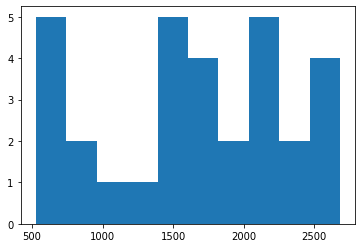

Lowest loc 527
Highest loc 2685
LQ Tests Done in total  : 1002
HQ Tests Done in total  : 0
Results Given in total  : 1002
Locations Moved in total: 905630
Tau Leap0 took 244.46073412895203
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 

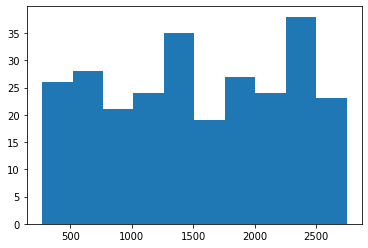

Lowest loc 270
Highest loc 2749
LQ Tests Done in total  : 10008
HQ Tests Done in total  : 0
Results Given in total  : 10008
Locations Moved in total: 906609
Tau Leap1 took 242.4143648147583
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 

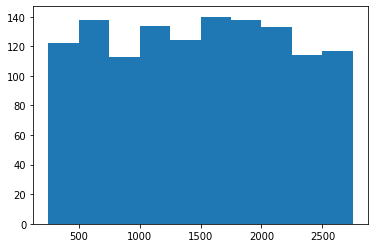

Lowest loc 252
Highest loc 2749
LQ Tests Done in total  : 50080
HQ Tests Done in total  : 0
Results Given in total  : 50080
Locations Moved in total: 903028
Tau Leap2 took 229.11178922653198
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 

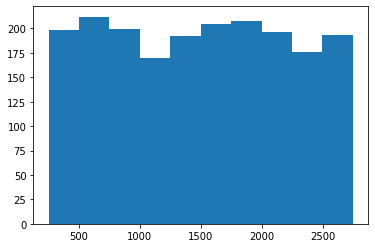

Lowest loc 252
Highest loc 2744
LQ Tests Done in total  : 75111
HQ Tests Done in total  : 0
Results Given in total  : 75111
Locations Moved in total: 903348
Tau Leap3 took 216.15021538734436
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 

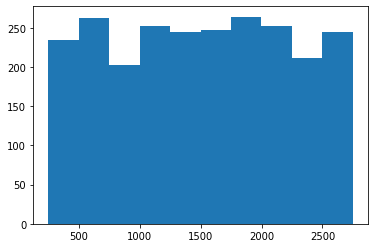

Lowest loc 250
Highest loc 2749
LQ Tests Done in total  : 100148
HQ Tests Done in total  : 0
Results Given in total  : 100148
Locations Moved in total: 900386
Tau Leap4 took 229.5965211391449


In [5]:
# Get Quenched Population

old_n_per_location = np.genfromtxt('../data/quenched_n_per_location.txt', delimiter=' ',dtype=int)
old_pop            = np.genfromtxt('../data/quenched_pop.txt', delimiter=' ',dtype=int)

link_weight = np.ones(n_pop,int)


Tpars  = np.array([[0.8, 1, 0],          # Low quality: sensitivity, specificity, result delay
                   [1.0, 1, 0]])         # High quality: sentitivity, specificity, result delay


tf=100

s = time.time()
tl_plot0 = Tau_Leap(rate_array, Cpars, Tpars, old_n, old_pop, old_n_per_location, tf,True,True,0.1)
e = time.time()
print("Tau Leap0 took "+str(e-s))


s = time.time()
tl_plot1 = Tau_Leap(rate_array, Cpars, Tpars, old_n, old_pop, old_n_per_location, tf,True,True,1)
e = time.time()
print("Tau Leap1 took "+str(e-s))

s = time.time()
tl_plot2 = Tau_Leap(rate_array, Cpars, Tpars, old_n, old_pop, old_n_per_location, tf,True,True,5)
e = time.time()
print("Tau Leap2 took "+str(e-s))

s = time.time()
tl_plot3 = Tau_Leap(rate_array, Cpars, Tpars, old_n, old_pop, old_n_per_location, tf,True,True,7.5)
e = time.time()
print("Tau Leap3 took "+str(e-s))

s = time.time()
tl_plot4 = Tau_Leap(rate_array, Cpars, Tpars, old_n, old_pop, old_n_per_location, tf,True,True,10)
e = time.time()
print("Tau Leap4 took "+str(e-s))


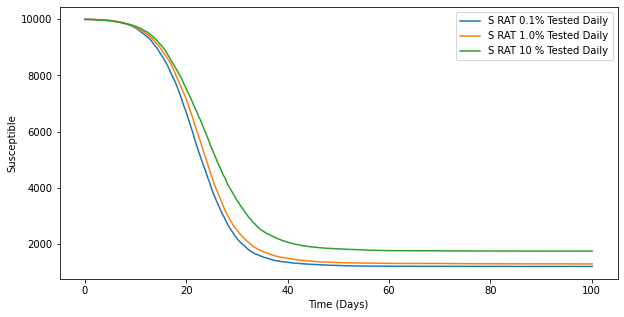

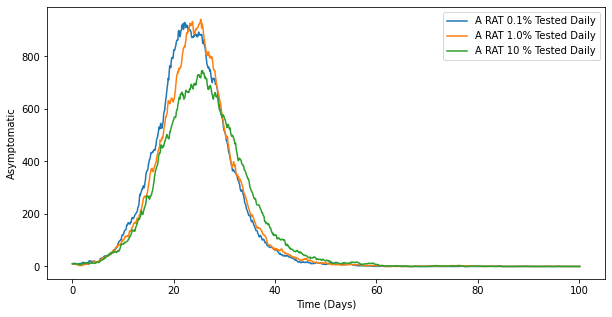

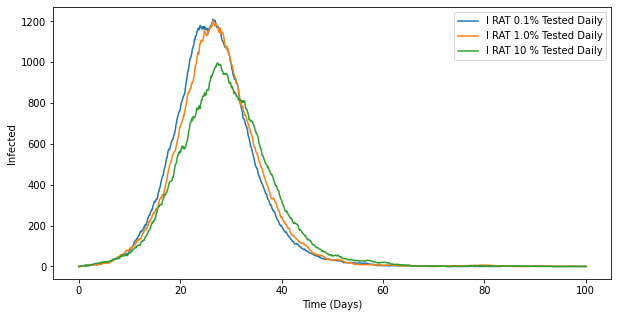

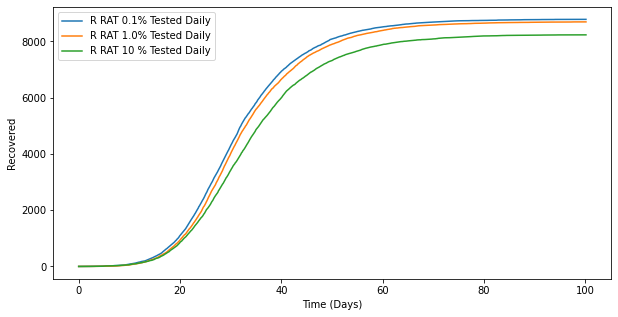

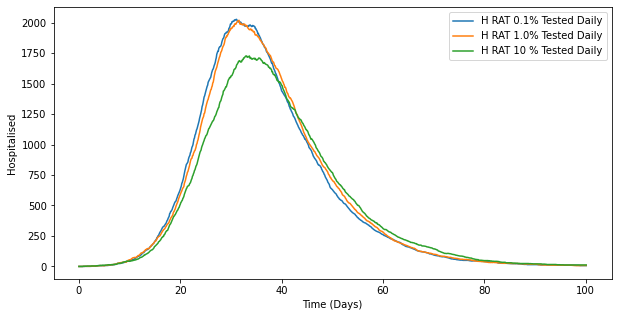

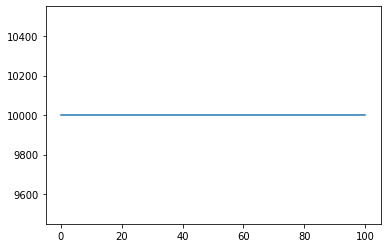

In [6]:
label_names = ["t","Susceptible","Asymptomatic","Infected","Recovered","Hospitalised"]
for i in range(1,6):
    plt.figure(figsize=(10,5))
    plt.plot(tl_plot0[:,0],tl_plot0[:,i],label=label_names[i][0]+r" RAT 0.1% Tested Daily")
    plt.plot(tl_plot1[:,0],tl_plot1[:,i],label=label_names[i][0]+r" RAT 1.0% Tested Daily")
    plt.plot(tl_plot2[:,0],tl_plot2[:,i],label=label_names[i][0]+r" RAT 10 % Tested Daily")
#     plt.plot(tl_plot3[:,0],tl_plot3[:,i],label=label_names[i][0]+r" (TL - Houses confined and $\beta$ reduced)")
    plt.xlabel("Time (Days)")
    plt.ylabel(label_names[i])
    plt.legend()
    #plt.legend(bbox_to_anchor=(1.5,1), loc="upper right")
    #plt.savefig("../images/"+str(i)+"_RAT_trajectory_"+label_names[i]+".png",facecolor='w')
    plt.show()
    
plt.plot(tl_plot1[:,0],tl_plot1[:,1]+tl_plot1[:,2]+tl_plot1[:,3]+tl_plot1[:,4]+tl_plot1[:,5])

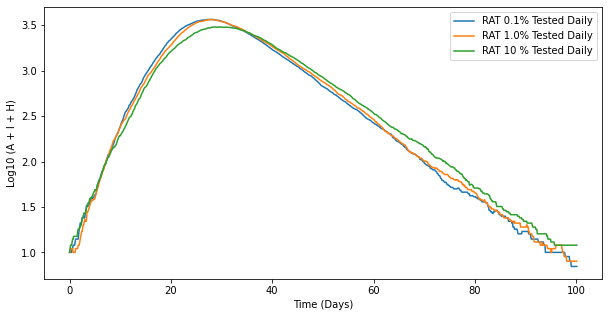

In [7]:
plt.figure(figsize=(10,5))
plt.plot(tl_plot1[:,0],np.log10(tl_plot0[:,2]+tl_plot0[:,3]+tl_plot0[:,5]),label=r"RAT 0.1% Tested Daily")
plt.plot(tl_plot1[:,0],np.log10(tl_plot1[:,2]+tl_plot1[:,3]+tl_plot1[:,5]),label=r"RAT 1.0% Tested Daily")
plt.plot(tl_plot2[:,0],np.log10(tl_plot2[:,2]+tl_plot2[:,3]+tl_plot2[:,5]),label=r"RAT 10 % Tested Daily")
# plt.plot(tl_plot3[:,0],np.log10(tl_plot3[:,2]+tl_plot3[:,3]+tl_plot3[:,5]),label=r" (Houses confined and $\beta$ reduced)")
plt.xlabel("Time (Days)")
plt.ylabel("Log10 (A + I + H)")

plt.legend()
#plt.savefig("../images/6_RAT_Trajectory_All_Infected_Log_Plot.png",facecolor='w')
plt.show()

In [8]:
import datetime
date = datetime.datetime.now()
dateString = date.strftime("-%Y-%b-%d_%H-%M-%S")

np.savetxt("../data/RAT_0.1_RandomTesting_"+dateString+".txt",tl_plot0, delimiter=" ")
np.savetxt("../data/RAT_1.0_RandomTesting_"+dateString+".txt",tl_plot1, delimiter=" ")
np.savetxt("../data/RAT_5.0_RandomTesting_"+dateString+".txt",tl_plot2, delimiter=" ")
np.savetxt("../data/RAT_7.5_RandomTesting_"+dateString+".txt",tl_plot3, delimiter=" ")
np.savetxt("../data/RAT_10._RandomTesting_"+dateString+".txt",tl_plot4, delimiter=" ")